How to use if you want to do the *INFERENCE*
- Download *checkpoints_baseline* from https://drive.google.com/drive/folders/1_13U4DmnYnTqc8FfvA7AL5pO5V5HDcTn. Make sure that the following path exists *"/baseline_experiments/checkpoints_baseline"*
- Run cells sequentially up to the *Training & Inference* section. Load Skil the training section by scrolling to the inference section
- Run the code blocks. You don't have to load models yourself, it is done automatically in the inference loops


If you want to train a model, just use the training section

In [1]:
%load_ext autoreload
%autoreload 2

### Load required packages

In [16]:
# !pip install torchmetrics  ### Run it if you dont have these libraries
# !pip install pytorch_lightning

In [3]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from utils import is_ne_in_df, to_numeric_and_downcast_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import ts_dataset as ds
import utils
import gc
import matplotlib.pyplot as plt

import torch
DEVICE=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

## Set up data & model parameters:

In [4]:

data_path = '../datasets/btc-usdt-1.csv'
timestamp_col_name = 'our_time'

print("Reading file in {}".format(data_path))

data = pd.read_csv(
    data_path, 
    parse_dates=[timestamp_col_name], 
    index_col=[timestamp_col_name], 
    infer_datetime_format=True,
    low_memory=False
)

# Make sure all "n/e" values have been removed from df. 
if is_ne_in_df(data):
    raise ValueError("data frame contains 'n/e' values. These must be handled")

data = to_numeric_and_downcast_data(data)

# Make sure data is in ascending order by timestamp
data.sort_values(by=[timestamp_col_name], inplace=True)

Reading file in ../datasets/btc-usdt-1.csv


In [6]:

price_data = pd.read_csv('../datasets/btc-usdt-1.csv')

input_data = ((price_data.bid_price + price_data.ask_price) / 2)

train_data, val_data = train_test_split(input_data.values, test_size=0.33, shuffle=False)
train_data.shape, val_data.shape

scaler = MinMaxScaler(feature_range=(-1, 1)) 
train_data = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(-1)
val_data = scaler.transform(val_data.reshape(-1, 1)).reshape(-1)    

In [7]:
def get_dataloader(data, enc_seq_len=60, dec_seq_len=120, step_size=1, batch_first=True, batch_size=None):
    '''
    E.g. if you want the model to consider the past 100
    time steps in order to predict the future 50 
    time steps, window_size = 100+50 = 150
    
    Args:
    
        enc_seq_len: int, length of input given to encoder

        dec_seq_len: int, length of input given to decoder
        
        step_size: int, Step size, i.e. how many time steps does the moving window move at each step
            
    '''
    
    output_sequence_length = dec_seq_len # target sequence length. If hourly data and length = 48, you predict 2 days ahead

    window_size = enc_seq_len + output_sequence_length # used to slice data into sub-sequences
   
    indices = utils.get_indices_entire_sequence(
        data=data, 
        window_size=window_size, 
        step_size=step_size
    )

    # Making instance of custom dataset class
    data = ds.TransformerDataset(
        data=torch.tensor(data).unsqueeze(1).float(),
        indices=indices,
        enc_seq_len=enc_seq_len,
        dec_seq_len=dec_seq_len,
        target_seq_len=output_sequence_length
    )

    # Making dataloader
    return DataLoader(data, batch_size, shuffle=False, num_workers=40) # replace 40 with your number

In [8]:
BATCH_SIZE=256

enc_seq_len=30
dec_seq_len=5

train_loader = get_dataloader(train_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)

From get_src_trg: data size = torch.Size([57888, 1])
From get_src_trg: data size = torch.Size([28512, 1])


d:\Anaconda\lib\site-packages\torch\utils\data\dataloader.py:563: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Training & Infernce

### Importing module with your model

In [15]:
import baseline as tst # replace with your model import
from model import SeqNet # needed

N_EPOCHS=120

backbone_net = tst.TimeSeriesTransformer(
    input_size=1, # num of input features
    dec_seq_len=dec_seq_len, # like in get_dataloader
    batch_first=True,
    num_predicted_features=1
)

model = SeqNet(
    backbone_net=backbone_net,
    forecast_window=dec_seq_len,
    enc_seq_len=enc_seq_len,
    n_epochs=N_EPOCHS, # needed for lr scheduling
).to(DEVICE)

# Training section. Skip it if you need the inference section

### Initializing logging and checkpointing params

In [43]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

wb_logger = pl.loggers.WandbLogger(
    name=f'TS_transformer_baseline|n_epochs={N_EPOCHS}|batch_size={BATCH_SIZE}|enc_seq_len={enc_seq_len}',
    project='sequential_data'
)

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    monitor='val_MSE', # name of SeqNet attribute
    filename='{epoch:02d}-{val_MSE:.3f}_3',
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=N_EPOCHS,
    logger=wb_logger,
    accelerator='gpu',
    devices=1,
    benchmark=True,
    callbacks=[checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
import wandb

trainer.fit(
    model=model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

wandb.finish()

/home/v_chernyy/myvenv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory /raid/data/DA_GNN/jupyters/seq_data/crypto-transformers/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | TimeSeriesTransformer | 29.4 M
1 | criterion | MSELoss               | 0     
2 | mae       | L1Loss                | 0     
3 | train_mse | MeanSquaredError      | 0     
4 | val_mse   | MeanSquaredError      | 0     
----------------------------------------------------
29.4 M    Trainable params
0         Non-trainable params
29.4 M    Total params
117.713   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Inference section

In [ ]:
list_of_checkpoints = [
    'checkpoints_baseline/epoch=00-val_mse=0.000_1.ckpt',
    'checkpoints_baseline/epoch=119-val_mse=0.000_2.ckpt',
    'checkpoints_baseline/epoch=119-val_MSE=1.501_3.ckpt',
    'checkpoints_baseline/epoch=119-val_MSE=1.503_4.ckpt',
    'checkpoints_baseline/epoch=119-val_MSE=1.505_5.ckpt',
    'checkpoints_baseline/epoch=42-val_MSE=1.497_6.ckpt'
]
hyperparams = [
    1,
    15,
    30,
    60,
    120,
    240
]

### Memory footprint

##### for every context length 'enc_seq_len' (which corresponds to a particular checkpoint), run a single inference loop and measure how much memory is used

In [ ]:
for enc_seq_len, checkpoint in zip(hyperparams, list_of_checkpoints):
    val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
    batch = next(iter(val_loader))
    batch = [x.cuda() for x in batch]
    backbone_net = tst.TimeSeriesTransformer(
        input_size=1, # num of input features
        dec_seq_len=dec_seq_len, # like in get_dataloader
        batch_first=True,
        num_predicted_features=1
    )

    model = SeqNet(
        backbone_net=backbone_net,
        forecast_window=dec_seq_len,
        enc_seq_len=enc_seq_len,
        n_epochs=N_EPOCHS, # needed for lr scheduling
    ).to(DEVICE)
    before_inference = torch.cuda.mem_get_info()[0]/1.049e+6 # converst bytes to mebibyte - a standard measure used in nvidia-smi
    with torch.no_grad():
        model.load_state_dict(torch.load(f'{checkpoint}')['state_dict'])
        y_pred = model(batch).flatten()
    after_inference = torch.cuda.mem_get_info()[0]/1.049e+6
    print(f'- - - - Seq length {enc_seq_len}, Memory used = {before_inference - after_inference}')
    del batch, model; torch.cuda.empty_cache(); gc.collect()

### Inference speed (with warm-up)

In [17]:
import time

In [18]:
def benchmark(model, src, tgt, src_mask, tgt_mask, dtype='fp32', nwarmup=50, nruns=1000, device='cuda', period=100):
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model.model(src, tgt, src_mask, tgt_mask)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model.model(src, tgt, src_mask, tgt_mask)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%period==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*nruns))

    print("Output features size:", features.size())

    print('Average batch time: %.2f ms'%(np.mean(timings)*nruns))

    return np.mean(timings)*nruns

In [ ]:
for enc_seq_len, checkpoint in zip(hyperparams, list_of_checkpoints):
    print(f'---- encoder seq len {enc_seq_len}')
    val_loader = get_dataloader(val_data, enc_seq_len, dec_seq_len, batch_size=BATCH_SIZE)
    batch = next(iter(val_loader))
    src = batch[0].to(DEVICE)
    tgt = batch[1].to(DEVICE)

    backbone_net = tst.TimeSeriesTransformer(
        input_size=1, # num of input features
        dec_seq_len=dec_seq_len, # like in get_dataloader
        batch_first=True,
        num_predicted_features=1
    )

    model = SeqNet(
        backbone_net=backbone_net,
        forecast_window=dec_seq_len,
        enc_seq_len=enc_seq_len,
        n_epochs=N_EPOCHS, # needed for lr scheduling
    ).to(DEVICE)
    with torch.no_grad():
        model.load_state_dict(torch.load(f'{checkpoint}')['state_dict'])
        src_mask, tgt_mask = model.src_mask.to(model.device), model.tgt_mask.to(model.device)
        benchmark(model, src, tgt, src_mask, tgt_mask)
    del batch, model; torch.cuda.empty_cache(); gc.collect()

### Model predictions quality

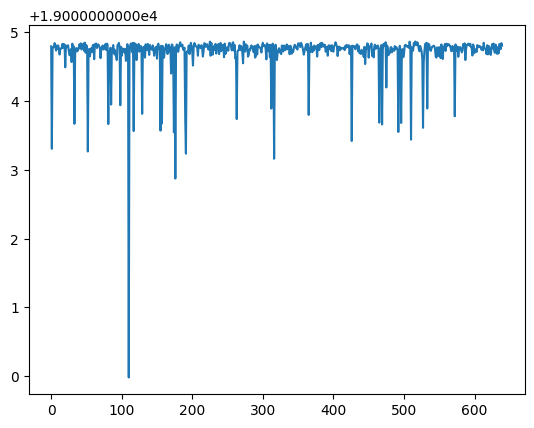

In [128]:
plt.plot(y_pred.detach().cpu().numpy())
# plt.yscale('log')
plt.show()

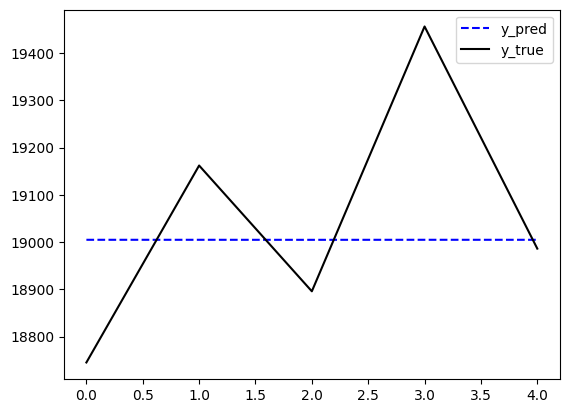

In [119]:
idx=13

plt.plot(y_pred.detach().squeeze().numpy()[-5:], 'b--', label='y_pred')

plt.plot(y_true[-5:], c='k', label='y_true')

plt.legend()
plt.show()